# Generate ECP in different dimensions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2d random

In [14]:
from src.bifiltration_utils import prune_contributions

rng = np.random.default_rng(seed=42)

contributions_2d = [
    (tuple(rng.integers(low=0, high=999, size=2)), rng.integers(low=-5, high=5))
    for _ in range(1000000)
]

contributions_2d = prune_contributions(contributions_2d)
print(len(contributions_2d))

572316


In [15]:
pd.DataFrame(data=[[row[0][0], row[0][1], row[1]] for row in contributions_2d]).to_csv(
    "data/2d_random_pts.csv", index=False, header=False, sep=" "
)

## Noisy circle

In [2]:
def generate_circle(NUMBER_OF_POINTS, seed=42, noise=False):
    point_cloud = []

    rng = np.random.default_rng(seed=seed)
    for a in np.linspace(0, 2 * np.pi, num=NUMBER_OF_POINTS, endpoint=False):
        point = [np.cos(a), np.sin(a)]

        if noise:
            point += rng.normal(scale=noise, size=2)

        point_cloud.append(point)

    point_cloud = np.array(point_cloud)

    return point_cloud


def generate_noisy_points(
    NUMBER_OF_POINTS, xmin=-0.2, xmax=0.2, ymin=-0.2, ymax=0.2, seed=42
):
    point_cloud = []

    rng = np.random.default_rng(seed=seed)

    for i in range(NUMBER_OF_POINTS):
        point_cloud.append([rng.uniform(xmin, xmax), rng.uniform(ymin, ymax)])

    point_cloud = np.array(point_cloud)

    return point_cloud

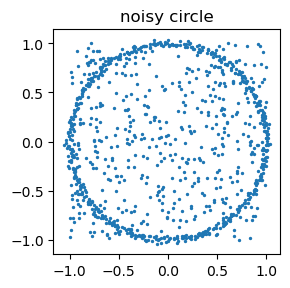

In [ ]:
EPSILON = 0.3
DSIGMA = 0.02
NUMBER_OF_POINTS = 200
NUMBER_OF_NOISE = 100

list_of_ECP = []

pointcloud = generate_circle(NUMBER_OF_POINTS, seed=42, noise=DSIGMA)

rng = np.random.default_rng(seed=42)
noisy_pointcloud = np.concatenate(
    (pointcloud, rng.uniform(low=-1, high=1, size=(NUMBER_OF_NOISE, 2)))
)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.scatter(noisy_pointcloud[:, 0], noisy_pointcloud[:, 1], s=2)
ax.axis("scaled")
ax.set_title("noisy circle")

plt.tight_layout()
plt.show()

## ECP with radius and density

In [4]:
import src.purepyECP as pure
from src.bifiltration_utils import EC_at_bifiltration, plot_ECP, difference_ECP

In [5]:
from sklearn.neighbors import NearestNeighbors

NN = 10

neigh = NearestNeighbors(n_neighbors=NN, radius=1)
neigh.fit(noisy_pointcloud)
dm, _ = neigh.kneighbors(noisy_pointcloud, NN, return_distance=True)
noisy_vertex_filtrations = dm[:, NN - 1]

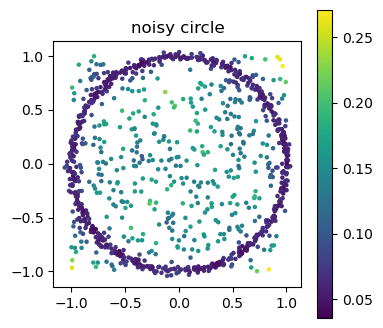

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

vmin = np.min(noisy_vertex_filtrations)
vmax = np.max(noisy_vertex_filtrations)

pts1 = ax.scatter(
    noisy_pointcloud[:, 0],
    noisy_pointcloud[:, 1],
    c=noisy_vertex_filtrations,
    vmin=vmin,
    vmax=vmax,
    s=5,
)
fig.colorbar(pts1)
ax.axis("scaled")
ax.set_title("noisy circle")

plt.show()

In [8]:
%%time
noisy_contributions, noisy_num_simplices = pure.compute_local_contributions(noisy_pointcloud, 
                                                                            EPSILON, noisy_vertex_filtrations)

  0%|          | 0/1000 [06:08<?, ?it/s]


KeyboardInterrupt: 

In [8]:
pd.DataFrame(
    data=[[row[0][0], row[0][1], row[1]] for row in noisy_contributions]
).to_csv("data/300_pts.csv", index=False, header=False, sep=" ")

In [9]:
pd.read_csv("data/300_pts.csv", sep=" ", header=None)

,0,1,2
0,0.000000,0.100785,1
1,0.000000,0.104976,1
2,0.000000,0.108591,1
3,0.000000,0.108759,1
4,0.000000,0.109182,1
...,...,...,...
962,0.294193,0.376306,1
963,0.297262,0.294640,1
964,0.298320,0.376306,-1
965,0.299694,0.115780,-1


0 0.2996943694817979 0.10078536533788429 0.4024226634116707


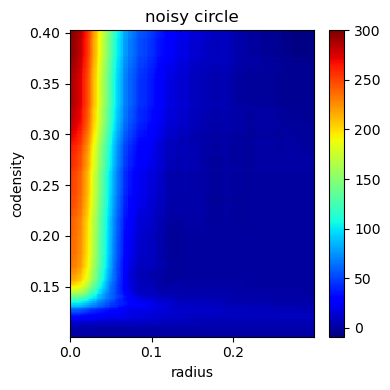

In [10]:
import matplotlib as mpl

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

f1max = max([c[0][0] for c in noisy_contributions])
f2max = max([c[0][1] for c in noisy_contributions])

f1min = min([c[0][0] for c in noisy_contributions])
f2min = min([c[0][1] for c in noisy_contributions])

print(f1min, f1max, f2min, f2max)

plot_ECP(
    noisy_contributions,
    (f1min, f1max, f2min, f2max),
    ax,
    # norm=mpl.colors.Normalize(vmin=-9, vmax=9),
    cmap="jet",
    colorbar=True,
)

ax.set_xlabel("radius")
ax.set_ylabel("codensity")
ax.set_title("noisy circle")

plt.tight_layout()

plt.show()

## discretize

In [11]:
def EC_at_bifiltration(contributions, f1, f2):
    return sum([c[1] for c in contributions if (c[0][0] <= f1) and (c[0][1] <= f2)])

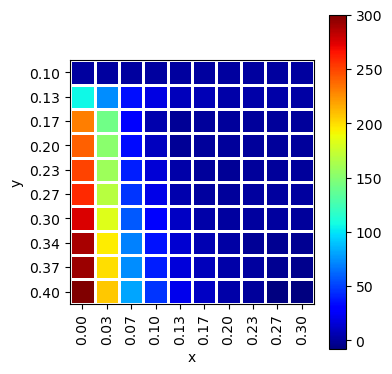

In [12]:
MIN_X = f1min
MAX_X = f1max

MIN_Y = f2max
MAX_Y = f2min

INCLUDE_ENDPOINT = True  # whether to include MAX value in the grid

GRIDSIZE = (10, 10)

## initializing matrix
M = np.zeros(GRIDSIZE, dtype=int)

# computing
for i, x in enumerate(
    np.linspace(start=MIN_X, stop=MAX_X, num=GRIDSIZE[0], endpoint=INCLUDE_ENDPOINT)
):
    for j, y in enumerate(
        np.linspace(start=MIN_Y, stop=MAX_Y, num=GRIDSIZE[1], endpoint=INCLUDE_ENDPOINT)
    ):
        M[j, i] = EC_at_bifiltration(noisy_contributions, x, y)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.pcolormesh(M, edgecolors="w", linewidth=1, cmap="jet")

ax.set_xlabel("x")
ax.set_xticks(
    [i + 0.5 for i in range(GRIDSIZE[0])],
    [
        "{:.2f}".format(l)
        for l in np.linspace(
            start=MIN_X, stop=MAX_X, num=GRIDSIZE[0], endpoint=INCLUDE_ENDPOINT
        )
    ],
    rotation=90,
)

ax.set_ylabel("y")
ax.set_yticks(
    [i + 0.5 for i in range(GRIDSIZE[1])],
    [
        "{:.2f}".format(l)
        for l in np.linspace(
            start=MIN_Y, stop=MAX_Y, num=GRIDSIZE[1], endpoint=INCLUDE_ENDPOINT
        )
    ],
)
plt.colorbar(im, ax=ax)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

# 3d ECP

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

from src.RGBcubical_utils import compute_RGB_contributions, difference_RGB_ECP

from tqdm.notebook import tqdm

(720, 561, 3)


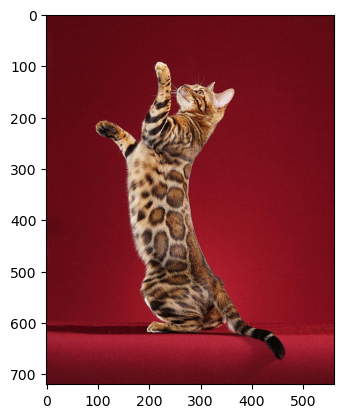

In [14]:
img = np.int16(Image.open("data/cat.jpg"))
print(img.shape)
plt.imshow(img)

In [15]:
RGB_contributions = compute_RGB_contributions(img)
print(len(RGB_contributions))

37076


In [16]:
## save
pd.DataFrame(
    data=[[row[0][0], row[0][1], row[0][2], row[1]] for row in RGB_contributions]
).to_csv("data/3d_cat_ECP.csv", index=False, header=False, sep=" ")

# 4d random ECP

In [17]:
import numpy as np

let us generate 100 random contributions with values on a 100x100x100x100 grid

In [20]:
rng = np.random.default_rng(seed=42)

contributions_4d = [
    (tuple(rng.integers(low=0, high=99, size=4)), rng.integers(low=-5, high=5))
    for _ in range(100)
]

contributions_4d

[((8, 76, 64, 43), -1),
 ((85, 8, 69, 19), -5),
 ((52, 96, 72, 75), 2),
 ((77, 50, 12, 83), -1),
 ((49, 36, 18, 91), 2),
 ((63, 39, 81, 53), -1),
 ((44, 22, 9, 54), 3),
 ((6, 84, 81, 27), 1),
 ((16, 75, 69, 35), -5),
 ((96, 44, 88, 67), 2),
 ((75, 19, 36, 46), -1),
 ((4, 54, 15, 73), 1),
 ((91, 73, 36, 95), -1),
 ((32, 89, 36, 7), -1),
 ((78, 18, 45, 12), 1),
 ((47, 32, 22, 55), 1),
 ((93, 43, 15, 82), 1),
 ((69, 9, 30, 76), 3),
 ((43, 79, 83, 38), 3),
 ((28, 23, 67, 63), -4),
 ((82, 19, 79, 0), 2),
 ((77, 77, 65, 46), 2),
 ((27, 77, 55, 45), 0),
 ((56, 3, 13, 24), -4),
 ((43, 66, 64, 46), 3),
 ((55, 7, 75, 56), 1),
 ((55, 54, 8, 55), 2),
 ((30, 59, 3, 34), -1),
 ((97, 21, 27, 40), 4),
 ((84, 3, 23, 81), -5),
 ((84, 27, 90, 29), -1),
 ((65, 12, 55, 49), 2),
 ((98, 65, 40, 40), -1),
 ((80, 31, 16, 33), -5),
 ((10, 8, 76, 71), 1),
 ((45, 70, 15, 89), 0),
 ((92, 15, 49, 68), -1),
 ((44, 16, 37, 23), -2),
 ((67, 62, 60, 35), 4),
 ((8, 33, 11, 33), 4),
 ((36, 89, 49, 69), -1),
 ((26, 75, 95

In [ ]:
assert len(np.unique([t[0] for t in contributions_4d], axis=1)) == 100

In [30]:
## save
pd.DataFrame(
    data=[
        [row[0][0], row[0][1], row[0][2], row[0][3], row[1]] for row in contributions_4d
    ]
).to_csv("data/4d_ECP.csv", index=False, header=False, sep=" ")